Import Necessary Libraries

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# ETL (Extract, Transform, Load)

## Load and explore the dataset

### Geothermal Gradients Dataset

In [41]:
gradients = pd.read_excel('data/Anexo 1. GRADIENTES GEOTÉRMICOS APARENTES.xlsx',sheet_name=1)
gradients = gradients.rename(columns={"Longitud": "Lon", "Latitud": "Lat"})
gradients.head()

,UWI,Nombre del Pozo,Profundidad Total \n(ft),Departamento,Cuenca,Lat,Lon,Coordenada\nX,Coordenada \n Y,Elevación GL\n(ft),Elevacion \n(m),Temperatura en superficie \n(°C),BHT\n(°F),BHT\n(°C),Profundidad BHT\n(ft),Profundidad BHT \n(m),Temperatura de formación (°C),Gradiente Geotérmico Aparente (°C/Km),Año de actualizacion del dato
0,ABAN0004,ABANICO-4,3020,Tolima,Valle Superior del Magdalena,4.213002,-74.893581,909770.865223,957357.370043,1030.0,313.9440,26.630280,100.0,37.777778,3020.0,920.4960,40.172876,14.712281,2008.0
1,ABAN0005,ABANICO-5,2928,Tolima,Valle Superior del Magdalena,4.216078,-74.888898,910291.244350,957696.956787,1028.0,313.3344,26.633328,110.0,43.333333,2928.0,892.4544,45.637603,21.294394,2008.0
2,ABAN0006,ABANICO-6,2904,Tolima,Valle Superior del Magdalena,4.214720,-74.891220,910033.263457,957547.084087,1038.0,316.3824,26.618088,113.0,45.000000,2842.0,866.2416,47.220262,23.783404,2008.0
3,ACAE0001,ACAE-1,10578,Putumayo,Caguan-Putumayo,0.606276,-76.564731,723420.331087,558549.884585,903.0,275.2344,26.823828,200.0,93.333333,10573.0,3222.6504,104.671211,24.156323,2008.0
4,ACAE0010,ACAE-10,10757,Putumayo,Caguan-Putumayo,0.305911,-76.914853,684390.184013,525315.148844,297.0,90.5256,27.747372,159.0,70.555556,6268.0,1910.4864,76.658202,25.601245,2008.0


### Moho Depth Dataset

In [42]:
moho_depth = pd.read_csv('data/south-american-moho.txt', delim_whitespace=True, comment="#", header=None, names=["Latitude", "Longitude", "Moho Depth (m)"])
moho_depth = moho_depth.rename(columns={"Longitude": "Lon", "Latitude": "Lat"})
moho_depth.head()

,Lat,Lon,Moho Depth (m)
0,-60.0,270.0,32674.89851
1,-60.0,270.4,26702.16351
2,-60.0,270.8,23617.60412
3,-60.0,271.2,22474.44981
4,-60.0,271.6,22003.43619


### Volcanos

In [43]:
volcanos = pd.read_csv('data/Volcanes_col.csv')
volcanos = volcanos.rename(columns={"X": "Lon", "Y": "Lat"})
volcanos.head()

,Lon,Lat,OBJECTID,VolcanID,NombreVolcan,AlturaSobreNivelMar,Latitud,Longitud,Comentarios,URL,GlobalID
0,-76.214977,1.916518,1,NaN,NaN,1800.0,"1° 54' 59,465"" N","76° 12' 53,917"" W",Edificio volcánico en el municipio de Isnos en...,NaN,071b82b6-5b8a-47d0-ba87-5ebfd34e4bac
1,-76.166495,2.232286,2,NaN,Volcan Santa Leticia,NaN,"2° 13' 56,229"" N","76° 9' 59,382"" W",NaN,NaN,f5a4cc3d-fc7e-46a1-b8d9-69fdcb4a541a
2,-76.082576,2.179546,3,NaN,Volcán El Pensil,2200.0,"2° 10' 46,366"" N","76° 4' 57,273"" W",NaN,NaN,e09ff266-bee3-4ea4-98df-8765b2c0b164
3,-76.217778,2.110280,4,NaN,Volcán El Dorado,2000.0,"2° 6' 37,008"" N","76° 13' 4,001"" W",NaN,NaN,073bdc7f-d632-4954-a383-cc1d4d083b7c
4,-76.477694,2.240949,5,NaN,Maar de Yerbabuena,3100.0,"2° 14' 27,415"" N","76° 28' 39,697"" W",NaN,NaN,d6077acc-cac2-4c9b-be59-64ba98040e8a


## Data Preprocessing

### Moho Depth

We need to convert the Longitude from 0, 360° to -180°, 180°

In [44]:
moho_depth["Lon"] = moho_depth["Lon"].apply(lambda x: x - 360 if x > 180 else x)

moho_depth.head()

,Lat,Lon,Moho Depth (m)
0,-60.0,-90.0,32674.89851
1,-60.0,-89.6,26702.16351
2,-60.0,-89.2,23617.60412
3,-60.0,-88.8,22474.44981
4,-60.0,-88.4,22003.43619


Crop the moho_depth dataset so that it fits within the spatial extent of the first dataset (geothermal gradient).

In [45]:
# Define the spatial extent boundaries from the "gradients" dataset
min_lat = gradients["Lat"].min()
max_lat = gradients["Lat"].max()
min_lon = gradients["Lon"].min()
max_lon = gradients["Lon"].max()

# Crop the "moho_depth" dataset to fit within the spatial extent of the "gradients" dataset
moho_depth= moho_depth[
    (moho_depth["Lat"] >= min_lat) & (moho_depth["Lat"] <= max_lat) &
    (moho_depth["Lon"] >= min_lon) & (moho_depth["Lon"] <= max_lon)
]

moho_depth.head()

,Lat,Lon,Moho Depth (m)
22830,0.4,-78.4,45833.63750
22831,0.4,-78.0,50558.10643
22832,0.4,-77.6,50195.81961
22833,0.4,-77.2,43388.77930
22834,0.4,-76.8,37111.13688


In [46]:
missing_values = moho_depth.isnull().sum()
missing_values

Lat               0
Lon               0
Moho Depth (m)    0
dtype: int64

### Gradients

In [47]:
# Check for missing values
missing_values = gradients.isnull().sum()
missing_values

UWI                                       32
Nombre del Pozo                           30
Profundidad Total \n(ft)                  33
Departamento                              38
Cuenca                                    38
Lat                                      100
Lon                                      100
Coordenada\nX                             38
Coordenada \n Y                           38
Elevación GL\n(ft)                       444
Elevacion \n(m)                           38
Temperatura en superficie \n(°C)          38
BHT\n(°F)                                 38
BHT\n(°C)                                 38
Profundidad BHT\n(ft)                     38
Profundidad BHT \n(m)                     38
Temperatura de formación (°C)             38
Gradiente Geotérmico Aparente (°C/Km)     38
Año de actualizacion del dato             38
dtype: int64

Remove rows without geothermal gradient, latitude or longitude values

In [48]:
gradients = gradients.dropna(subset=["Gradiente Geotérmico Aparente (°C/Km)"])
gradients = gradients.dropna(subset=["Lat", "Lon"])

gradients.tail()

,UWI,Nombre del Pozo,Profundidad Total \n(ft),Departamento,Cuenca,Lat,Lon,Coordenada\nX,Coordenada \n Y,Elevación GL\n(ft),Elevacion \n(m),Temperatura en superficie \n(°C),BHT\n(°F),BHT\n(°C),Profundidad BHT\n(ft),Profundidad BHT \n(m),Temperatura de formación (°C),Gradiente Geotérmico Aparente (°C/Km),Año de actualizacion del dato
4600,ZENO0001,ZENON-1,6422,Bolivar,Valle Inferior del Magdalena,9.198753,-74.545831,9.489047e+05,1.508724e+06,49.0,14.9352,28.125324,152.0,66.666667,6423.0,1957.7304,72.962956,22.902864,2008.0
4601,ZENO0002,ZENON-2,6196,Bolivar,Valle Inferior del Magdalena,9.193783,-74.545203,9.489730e+05,1.508175e+06,58.0,17.6784,28.111608,152.0,66.666667,6196.0,1888.5408,72.679641,23.599190,2008.0
4602,ZENO0003,ZENON-3,6559,Magdalena,Valle Inferior del Magdalena,9.210378,-74.266786,9.795733e+05,1.509982e+06,70.0,21.3360,28.093320,152.0,66.666667,6559.0,1999.1832,73.133462,22.529272,2008.0
4603,ZULI0001W,ZULIA WEST-1,7655,Norte de Santander,Catatumbo,8.213381,-72.470731,1.177448e+06,1.400064e+06,285.0,86.8680,27.765660,166.0,74.444444,7765.0,2366.7720,82.434751,23.098588,2008.0
4604,ZULI0001E,ZULIA-1 EAST,3361.5,Norte de Santander,Catatumbo,8.202650,-72.439292,1.180919e+06,1.398891e+06,NaN,114.0000,27.630000,112.0,44.444444,3410.0,1039.3680,47.235248,18.862662,2008.0


In [49]:
missing_values = gradients.isnull().sum()
missing_values

UWI                                        0
Nombre del Pozo                            0
Profundidad Total \n(ft)                   0
Departamento                               0
Cuenca                                     0
Lat                                        0
Lon                                        0
Coordenada\nX                              0
Coordenada \n Y                            0
Elevación GL\n(ft)                       348
Elevacion \n(m)                            0
Temperatura en superficie \n(°C)           0
BHT\n(°F)                                  0
BHT\n(°C)                                  0
Profundidad BHT\n(ft)                      0
Profundidad BHT \n(m)                      0
Temperatura de formación (°C)              0
Gradiente Geotérmico Aparente (°C/Km)      0
Año de actualizacion del dato              0
dtype: int64

In [50]:
for col in gradients.columns:
    print(col)

UWI
Nombre del Pozo
Profundidad Total 
(ft)
Departamento
Cuenca
Lat
Lon
Coordenada
X
Coordenada 
 Y
Elevación GL
(ft)
Elevacion 
(m)
Temperatura en superficie 
(°C)
BHT
(°F)
BHT
(°C)
Profundidad BHT
(ft)
Profundidad BHT 
(m)
Temperatura de formación (°C)
Gradiente Geotérmico Aparente (°C/Km)
Año de actualizacion del dato


### Volcanos

In [51]:
missing_values = volcanos.isnull().sum()
missing_values

Lon                     0
Lat                     0
OBJECTID                0
VolcanID               61
NombreVolcan           14
AlturaSobreNivelMar     4
Latitud                 0
Longitud                0
Comentarios            54
URL                    41
GlobalID                0
dtype: int64

There's not much to do with volcanos dataset as they don't have missing Lon and Lat values.

## Feature Engineering

### Distance to nearest volcano

In [52]:
import geopandas as gpd
from shapely.geometry import Point
import math

In [53]:
# Load the "gradients" and "volcanos" datasets into GeoDataFrames
gradients_gdf = gpd.GeoDataFrame(gradients, geometry=gpd.points_from_xy(gradients['Lon'], gradients['Lat']))
volcanos_gdf = gpd.GeoDataFrame(volcanos, geometry=gpd.points_from_xy(volcanos['Lon'], volcanos['Lat']))

# Initialize an empty list to store distances to the nearest volcano (in meters)
distances_to_nearest_volcano = []

# Radius of the Earth in meters
earth_radius = 6371000  # Approximately

# Iterate through each well
for well in gradients_gdf.itertuples():
    nearest_volcano_distance = float('inf')  # Initialize with a large value
    
    # Iterate through each volcano to find the nearest one
    for volcano in volcanos_gdf.itertuples():
        # Haversine formula to calculate the great-circle distance
        lon1, lat1 = well.geometry.x, well.geometry.y
        lon2, lat2 = volcano.geometry.x, volcano.geometry.y

        dlon = math.radians(lon2 - lon1)
        dlat = math.radians(lat2 - lat1)

        a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

        distance = earth_radius * c
        nearest_volcano_distance = min(nearest_volcano_distance, distance)
    
    distances_to_nearest_volcano.append(nearest_volcano_distance)

# Add the distances to the "gradients" dataset as a new column (in meters)
gradients['Distance_To_Nearest_Volcano (m)'] = distances_to_nearest_volcano

In [54]:
gradients.head()

,UWI,Nombre del Pozo,Profundidad Total \n(ft),Departamento,Cuenca,Lat,Lon,Coordenada\nX,Coordenada \n Y,Elevación GL\n(ft),Elevacion \n(m),Temperatura en superficie \n(°C),BHT\n(°F),BHT\n(°C),Profundidad BHT\n(ft),Profundidad BHT \n(m),Temperatura de formación (°C),Gradiente Geotérmico Aparente (°C/Km),Año de actualizacion del dato,Distance_To_Nearest_Volcano (m)
0,ABAN0004,ABANICO-4,3020,Tolima,Valle Superior del Magdalena,4.213002,-74.893581,909770.865223,957357.370043,1030.0,313.9440,26.630280,100.0,37.777778,3020.0,920.4960,40.172876,14.712281,2008.0,37601.741109
1,ABAN0005,ABANICO-5,2928,Tolima,Valle Superior del Magdalena,4.216078,-74.888898,910291.244350,957696.956787,1028.0,313.3344,26.633328,110.0,43.333333,2928.0,892.4544,45.637603,21.294394,2008.0,37852.172379
2,ABAN0006,ABANICO-6,2904,Tolima,Valle Superior del Magdalena,4.214720,-74.891220,910033.263457,957547.084087,1038.0,316.3824,26.618088,113.0,45.000000,2842.0,866.2416,47.220262,23.783404,2008.0,37716.838356
3,ACAE0001,ACAE-1,10578,Putumayo,Caguan-Putumayo,0.606276,-76.564731,723420.331087,558549.884585,903.0,275.2344,26.823828,200.0,93.333333,10573.0,3222.6504,104.671211,24.156323,2008.0,74806.593793
4,ACAE0010,ACAE-10,10757,Putumayo,Caguan-Putumayo,0.305911,-76.914853,684390.184013,525315.148844,297.0,90.5256,27.747372,159.0,70.555556,6268.0,1910.4864,76.658202,25.601245,2008.0,84902.242439


### Volcanos nearby (within radius = nearest volcano + 5 Km)

In [55]:
import geopy.distance

# The radius is the distance to the nearest volcano plus 5000 meters (5 kilometers)
gradients['Radius (m)'] = gradients['Distance_To_Nearest_Volcano (m)'] + 5000

# Initialize an empty list to store the counts of nearby volcanoes
num_volcanoes_nearby = []

# Iterate through each well to count nearby volcanoes
for index, row in gradients.iterrows():
    well_location = (row['Lat'], row['Lon'])
    radius = row['Radius (m)']
    
    # Calculate the number of volcanoes within the specified radius
    num_nearby_volcanoes = len(volcanos[
        volcanos.apply(lambda x: geopy.distance.distance(well_location, (x['Lat'], x['Lon'])).m <= radius, axis=1)
    ])
    
    num_volcanoes_nearby.append(num_nearby_volcanoes)

# Add the "Number of Volcanoes Nearby" feature to the "gradients" dataset
gradients['Number of Volcanoes Nearby'] = num_volcanoes_nearby

# Verify the updated dataset
gradients.head()

,UWI,Nombre del Pozo,Profundidad Total \n(ft),Departamento,Cuenca,Lat,Lon,Coordenada\nX,Coordenada \n Y,Elevación GL\n(ft),...,BHT\n(°F),BHT\n(°C),Profundidad BHT\n(ft),Profundidad BHT \n(m),Temperatura de formación (°C),Gradiente Geotérmico Aparente (°C/Km),Año de actualizacion del dato,Distance_To_Nearest_Volcano (m),Radius (m),Number of Volcanoes Nearby
0,ABAN0004,ABANICO-4,3020,Tolima,Valle Superior del Magdalena,4.213002,-74.893581,909770.865223,957357.370043,1030.0,...,100.0,37.777778,3020.0,920.4960,40.172876,14.712281,2008.0,37601.741109,42601.741109,2
1,ABAN0005,ABANICO-5,2928,Tolima,Valle Superior del Magdalena,4.216078,-74.888898,910291.244350,957696.956787,1028.0,...,110.0,43.333333,2928.0,892.4544,45.637603,21.294394,2008.0,37852.172379,42852.172379,2
2,ABAN0006,ABANICO-6,2904,Tolima,Valle Superior del Magdalena,4.214720,-74.891220,910033.263457,957547.084087,1038.0,...,113.0,45.000000,2842.0,866.2416,47.220262,23.783404,2008.0,37716.838356,42716.838356,2
3,ACAE0001,ACAE-1,10578,Putumayo,Caguan-Putumayo,0.606276,-76.564731,723420.331087,558549.884585,903.0,...,200.0,93.333333,10573.0,3222.6504,104.671211,24.156323,2008.0,74806.593793,79806.593793,5
4,ACAE0010,ACAE-10,10757,Putumayo,Caguan-Putumayo,0.305911,-76.914853,684390.184013,525315.148844,297.0,...,159.0,70.555556,6268.0,1910.4864,76.658202,25.601245,2008.0,84902.242439,89902.242439,5


### Moho Depth

In [56]:
# Load the "gradients" and "moho_depth" datasets into GeoDataFrames
gradients_gdf = gpd.GeoDataFrame(gradients, geometry=gpd.points_from_xy(gradients['Lon'], gradients['Lat']))
moho_depth_gdf = gpd.GeoDataFrame(moho_depth, geometry=gpd.points_from_xy(moho_depth['Lon'], moho_depth['Lat']))

# Initialize an empty list to store Moho depth values for each well
moho_depth_values = []

# Iterate through each well
for well in gradients_gdf.itertuples():
    nearest_moho_depth = None
    
    # Iterate through each Moho depth location to find the nearest one
    for moho_location in moho_depth_gdf.itertuples():
        distance = well.geometry.distance(moho_location.geometry)
        
        if nearest_moho_depth is None or distance < nearest_moho_depth[0]:
            nearest_moho_depth = (distance, moho_location._3)  # Access the Moho depth attribute using dot notation
    
    # Append the Moho depth value to the list
    moho_depth_values.append(nearest_moho_depth[1] if nearest_moho_depth else None)

# Add the Moho depth values to the "gradients" dataset as a new column
gradients['Moho_Depth (m)'] = moho_depth_values

In [57]:
gradients.head()

,UWI,Nombre del Pozo,Profundidad Total \n(ft),Departamento,Cuenca,Lat,Lon,Coordenada\nX,Coordenada \n Y,Elevación GL\n(ft),...,BHT\n(°C),Profundidad BHT\n(ft),Profundidad BHT \n(m),Temperatura de formación (°C),Gradiente Geotérmico Aparente (°C/Km),Año de actualizacion del dato,Distance_To_Nearest_Volcano (m),Radius (m),Number of Volcanoes Nearby,Moho_Depth (m)
0,ABAN0004,ABANICO-4,3020,Tolima,Valle Superior del Magdalena,4.213002,-74.893581,909770.865223,957357.370043,1030.0,...,37.777778,3020.0,920.4960,40.172876,14.712281,2008.0,37601.741109,42601.741109,2,42722.81991
1,ABAN0005,ABANICO-5,2928,Tolima,Valle Superior del Magdalena,4.216078,-74.888898,910291.244350,957696.956787,1028.0,...,43.333333,2928.0,892.4544,45.637603,21.294394,2008.0,37852.172379,42852.172379,2,42722.81991
2,ABAN0006,ABANICO-6,2904,Tolima,Valle Superior del Magdalena,4.214720,-74.891220,910033.263457,957547.084087,1038.0,...,45.000000,2842.0,866.2416,47.220262,23.783404,2008.0,37716.838356,42716.838356,2,42722.81991
3,ACAE0001,ACAE-1,10578,Putumayo,Caguan-Putumayo,0.606276,-76.564731,723420.331087,558549.884585,903.0,...,93.333333,10573.0,3222.6504,104.671211,24.156323,2008.0,74806.593793,79806.593793,5,36748.55113
4,ACAE0010,ACAE-10,10757,Putumayo,Caguan-Putumayo,0.305911,-76.914853,684390.184013,525315.148844,297.0,...,70.555556,6268.0,1910.4864,76.658202,25.601245,2008.0,84902.242439,89902.242439,5,37111.13688


## Dataset cleaning

In [58]:
# Convert "Profundidad BHT (ft)" to meters (1 ft = 0.3048 m)
gradients['Profundidad BHT (m)'] = gradients['Profundidad BHT\n(ft)'] * 0.3048


In [59]:
selected_columns = [
    'Cuenca',
    'Nombre del Pozo',
    'Profundidad BHT (m)',
    'Lat',
    'Lon',
    'Temperatura en superficie \n(°C)',
    'Temperatura de formación (°C)',
    'Gradiente Geotérmico Aparente (°C/Km)',
    'Distance_To_Nearest_Volcano (m)',
    'Number of Volcanoes Nearby',
    'Moho_Depth (m)'
]

cleaned_data = gradients[selected_columns]

In [60]:
cleaned_data.head()

,Cuenca,Nombre del Pozo,Profundidad BHT (m),Lat,Lon,Temperatura en superficie \n(°C),Temperatura de formación (°C),Gradiente Geotérmico Aparente (°C/Km),Distance_To_Nearest_Volcano (m),Number of Volcanoes Nearby,Moho_Depth (m)
0,Valle Superior del Magdalena,ABANICO-4,920.4960,4.213002,-74.893581,26.630280,40.172876,14.712281,37601.741109,2,42722.81991
1,Valle Superior del Magdalena,ABANICO-5,892.4544,4.216078,-74.888898,26.633328,45.637603,21.294394,37852.172379,2,42722.81991
2,Valle Superior del Magdalena,ABANICO-6,866.2416,4.214720,-74.891220,26.618088,47.220262,23.783404,37716.838356,2,42722.81991
3,Caguan-Putumayo,ACAE-1,3222.6504,0.606276,-76.564731,26.823828,104.671211,24.156323,74806.593793,5,36748.55113
4,Caguan-Putumayo,ACAE-10,1910.4864,0.305911,-76.914853,27.747372,76.658202,25.601245,84902.242439,5,37111.13688


Change column names for better homogeneity

In [61]:
# Define a dictionary to specify the new column names
cleaned_data = cleaned_data.copy()

column_mapping = {
    'Cuenca': 'Basin',
    'Nombre del Pozo': 'Well Name',
    'Profundidad BHT (m)': 'BHT Depth (m)',
    'Lat': 'Lat',
    'Lon': 'Lon',
    'Temperatura en superficie \n(°C)': 'Surface Temperature (°C)',
    'Temperatura de formación (°C)': 'Formation Temperature (°C)',
    'Gradiente Geotérmico Aparente (°C/Km)': 'Apparent Geothermal Gradient (°C/Km)',
    'Distance_To_Nearest_Volcano (m)': 'Distance To Nearest Volcano (m)',
    'Number of Volcanoes Nearby': 'Number of Volcanoes Nearby',
    'Moho_Depth (m)': 'Moho Depth (m)'
}

# Rename the columns in the DataFrame
cleaned_data.rename(columns=column_mapping, inplace=True)

# Verify the renamed DataFrame
cleaned_data.head()


,Basin,Well Name,BHT Depth (m),Lat,Lon,Surface Temperature (°C),Formation Temperature (°C),Apparent Geothermal Gradient (°C/Km),Distance To Nearest Volcano (m),Number of Volcanoes Nearby,Moho Depth (m)
0,Valle Superior del Magdalena,ABANICO-4,920.4960,4.213002,-74.893581,26.630280,40.172876,14.712281,37601.741109,2,42722.81991
1,Valle Superior del Magdalena,ABANICO-5,892.4544,4.216078,-74.888898,26.633328,45.637603,21.294394,37852.172379,2,42722.81991
2,Valle Superior del Magdalena,ABANICO-6,866.2416,4.214720,-74.891220,26.618088,47.220262,23.783404,37716.838356,2,42722.81991
3,Caguan-Putumayo,ACAE-1,3222.6504,0.606276,-76.564731,26.823828,104.671211,24.156323,74806.593793,5,36748.55113
4,Caguan-Putumayo,ACAE-10,1910.4864,0.305911,-76.914853,27.747372,76.658202,25.601245,84902.242439,5,37111.13688


### Normalization of the data

Data needs to be normalized as the features are in different scales

In [62]:
from sklearn.preprocessing import MinMaxScaler

features_to_normalize = ['BHT Depth (m)', 'Formation Temperature (°C)', 'Surface Temperature (°C)', 'Distance To Nearest Volcano (m)', 'Number of Volcanoes Nearby', 'Moho Depth (m)']
scaler = MinMaxScaler()
cleaned_data[features_to_normalize] = scaler.fit_transform(cleaned_data[features_to_normalize])

In [63]:
cleaned_data.head()

,Basin,Well Name,BHT Depth (m),Lat,Lon,Surface Temperature (°C),Formation Temperature (°C),Apparent Geothermal Gradient (°C/Km),Distance To Nearest Volcano (m),Number of Volcanoes Nearby,Moho Depth (m)
0,Valle Superior del Magdalena,ABANICO-4,0.072760,4.213002,-74.893581,0.899248,0.022287,14.712281,0.034231,0.142857,0.708538
1,Valle Superior del Magdalena,ABANICO-5,0.067902,4.216078,-74.888898,0.899443,0.060783,21.294394,0.034546,0.142857,0.708538
2,Valle Superior del Magdalena,ABANICO-6,0.063361,4.214720,-74.891220,0.898465,0.071932,23.783404,0.034375,0.142857,0.708538
3,Caguan-Putumayo,ACAE-1,0.471567,0.606276,-76.564731,0.911671,0.476645,24.156323,0.080993,0.571429,0.440061
4,Caguan-Putumayo,ACAE-10,0.244258,0.305911,-76.914853,0.970948,0.279308,25.601245,0.093682,0.571429,0.456355


Let's save the cleaned and normalized dataframe as a file

In [64]:
cleaned_data.to_csv('cleaned_data_normalized.csv', index=False)

In [65]:
cleaned_data = pd.read_csv('cleaned_data_normalized.csv')

## Correlation Matrix

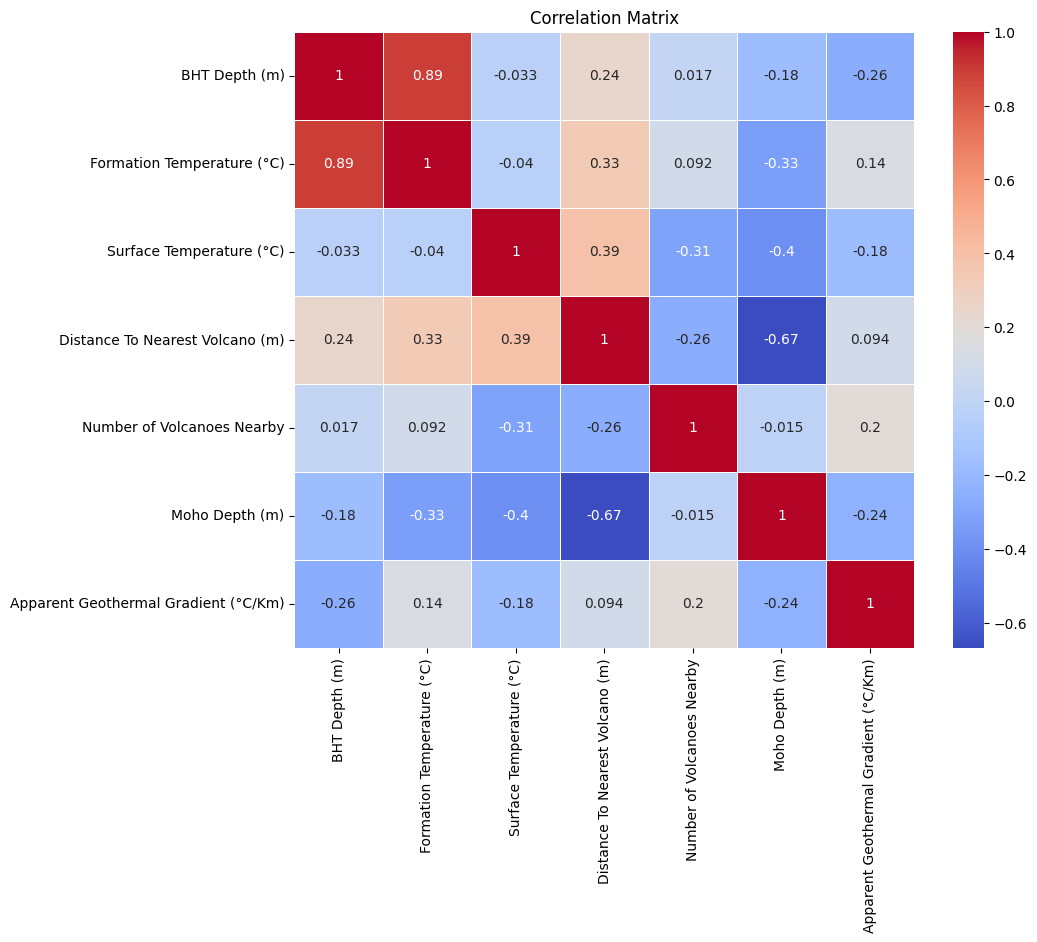

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the desired columns
selected_columns = ['BHT Depth (m)', 'Formation Temperature (°C)', 'Surface Temperature (°C)','Distance To Nearest Volcano (m)', 'Number of Volcanoes Nearby', 'Moho Depth (m)', 'Apparent Geothermal Gradient (°C/Km)']

# Create a DataFrame with the selected columns
selected_data = cleaned_data[selected_columns]

# Calculate the correlation matrix
correlation_matrix = selected_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


## Box plot for categorical feature (Basin)

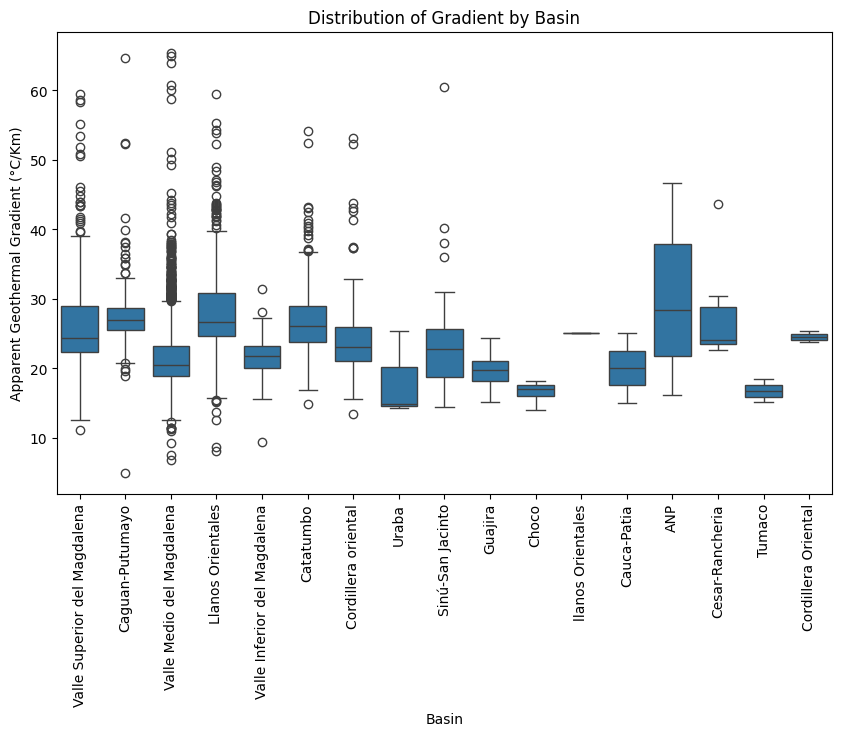

In [67]:
# Create a box plot to visualize the distribution of "Apparent Geothermal Gradient (°C/Km)" by basin
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
sns.boxplot(x='Basin', y='Apparent Geothermal Gradient (°C/Km)', data=cleaned_data)
plt.xlabel('Basin')
plt.ylabel('Apparent Geothermal Gradient (°C/Km)')
plt.title('Distribution of Gradient by Basin')
plt.show()

Apparent Geothermal Gradient has a weak correlation with the features we got, so it's possible that our relations in the data are non-linear. Therefore, we should work with a non-linear model such as Gradient Boosting or Random Forest.

Basins seem to have some correlation/influence with the geothermal gradient, as some basins have a huge range of gradients and some others have a very short range.

# Building Machine Learning Algorythm

## Data Splitting

In [68]:
# Define feature matrix (X) and target variable (y)
X = cleaned_data[['Basin', 'BHT Depth (m)', 'Formation Temperature (°C)', 'Surface Temperature (°C)', 'Distance To Nearest Volcano (m)', 'Number of Volcanoes Nearby', 'Moho Depth (m)']]
y = cleaned_data['Apparent Geothermal Gradient (°C/Km)']

# One Hot Encoding for Basins
X = pd.get_dummies(X, columns=['Basin'], drop_first=True)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Hyperparameter Tuning with Cross-Validation

Manually iterating over hyperparameter combinations and recording the progress using the tqdm library. 

In [69]:
from tqdm import tqdm
import itertools
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Perform grid search manually with a progress bar
param_grid_combinations = list(ParameterGrid(param_grid))
total_combinations = len(param_grid_combinations)

results = []

with tqdm(total=total_combinations) as pbar:
    for params in param_grid_combinations:
        rf_model.set_params(**params)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        results.append((params, mse))
        pbar.update()

# Find the best hyperparameters
best_params, best_mse = min(results, key=lambda x: x[1])
print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_mse)


  0%|          | 0/81 [00:00<?, ?it/s]

100%|██████████| 81/81 [02:58<00:00,  2.20s/it]

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Mean Squared Error: 1.5574997682171279


## Train Random Forest and evaluate model

In [70]:
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Evaluate the model's performance on the test data using appropriate regression metrics (e.g., MAE, RMSE, R-squared).

In [71]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = best_rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

In [72]:
print(mae)
print(rmse)
print(r2)

0.5187341922038634
1.2479983045730183
0.9600850173656308


MAE represents the average absolute difference between the predicted and actual values. A MAE of 0.5187 suggests that, on average, model's predictions are approximately 0.5187 °C/Km away from the true values. Lower MAE is generally better, but the "goodness" of the value depends on the context and domain knowledge.

RMSE measures the square root of the average squared differences between predicted and actual values. It penalizes larger errors more than MAE. RMSE of 1.2480 indicates that, on average, model's predictions deviate by approximately 1.2480 °C/Km from the true values. Smaller RMSE values are preferred.

R-squared, or the coefficient of determination, represents the proportion of the variance in the dependent variable that's predictable from the independent variables. An R² of 0.9600 suggests that the model explains approximately 96.00% of the variance in the target variable. A higher R² value is desirable, and 0.9600 is generally considered excellent.

# Visualization of results

## Feature Importance Plot

Visualize the importance of each feature in the Random Forest model. This will help to understand which features have the most significant impact on predicting the geothermal gradient.

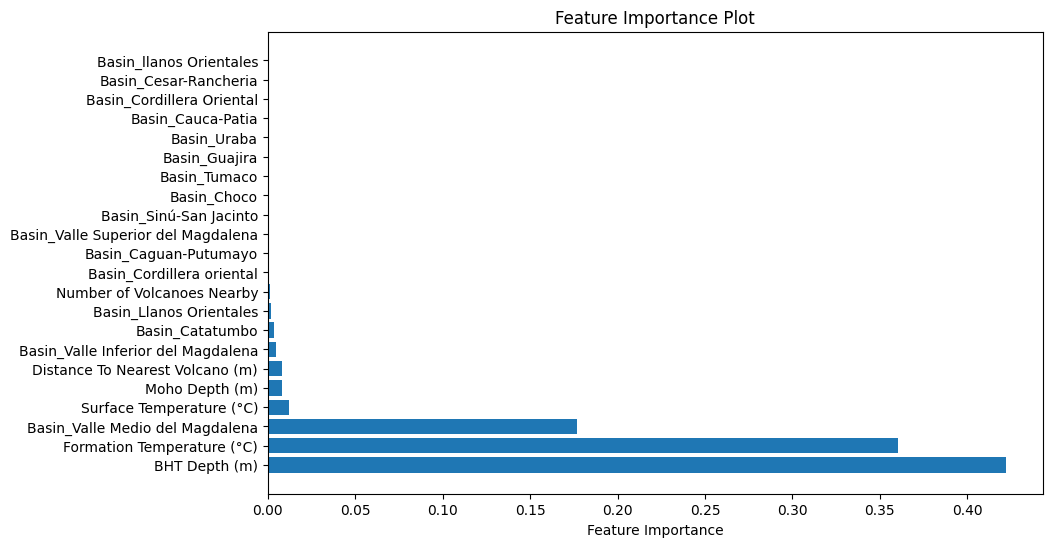

In [73]:
importances = best_rf_model.feature_importances_
feature_names = X.columns

# Sort importances in descending order
sorted_importances = sorted(zip(importances, feature_names), reverse=True)
top_features = [feature for importance, feature in sorted_importances]

plt.figure(figsize=(10, 6))
plt.barh(top_features, [importance for importance, _ in sorted_importances])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.show()

## Residual Plot

Create a residual plot to check if the model's predictions have a pattern. Most residuals must be randomly scattered around zero.

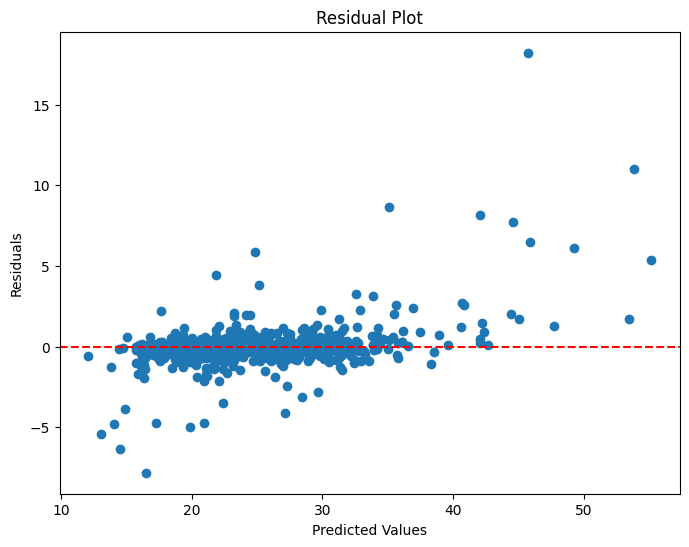

In [74]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.show()

## Actual vs. Predicted Plot

Visualize how model's predictions compare to the actual values.

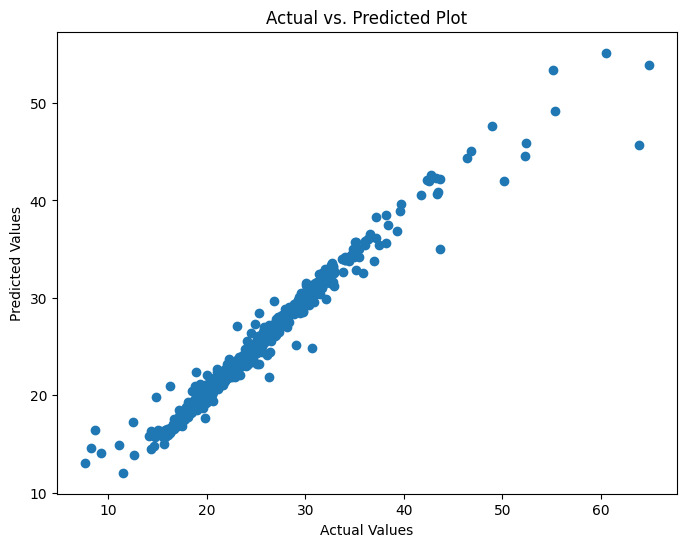

In [75]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Plot')
plt.show()

## Partial Dependency Plots

Understand the relationship between a specific feature and the target while keeping other features constant.

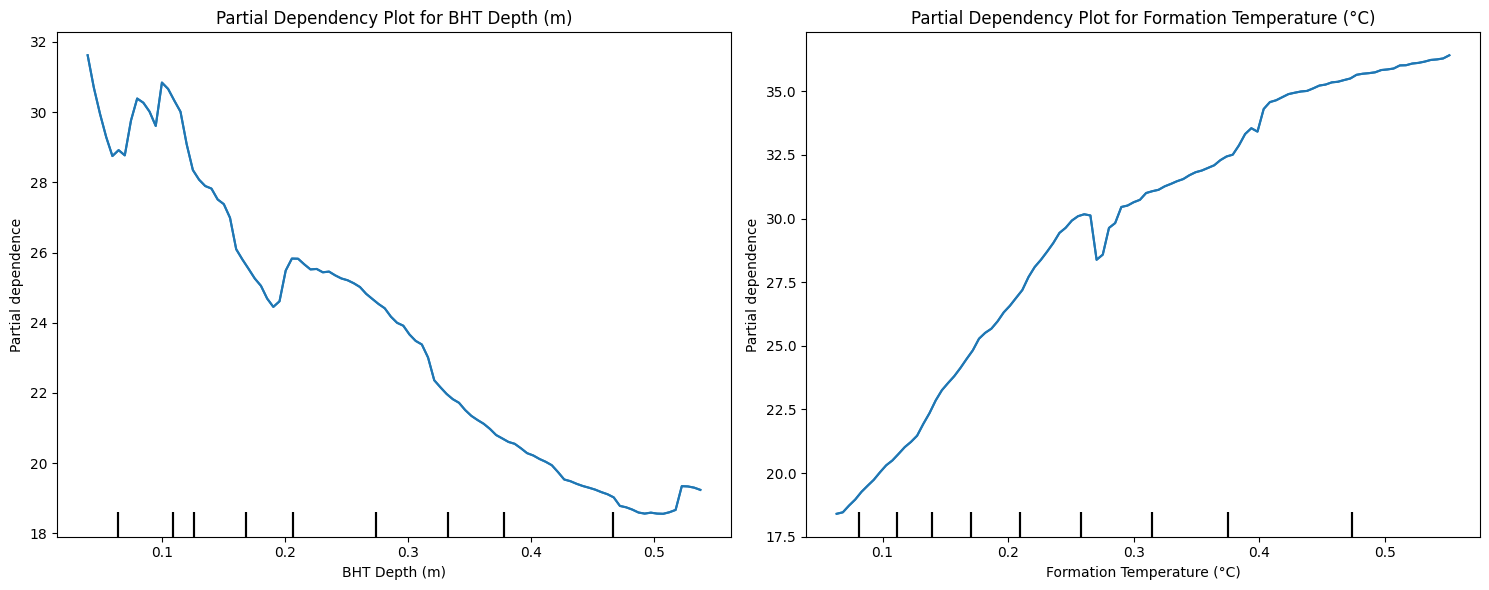

In [76]:
from sklearn.inspection import PartialDependenceDisplay

feature_indices = [X.columns.get_loc("BHT Depth (m)"), X.columns.get_loc("Formation Temperature (°C)")]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Create a single row with 2 subplots

for i, feature_index in enumerate(feature_indices):
    ax = axes[i]  # Select the appropriate subplot
    display = PartialDependenceDisplay.from_estimator(best_rf_model, X_train, features=[feature_index], ax=ax)
    display.plot(ax=display.axes_)
    ax.set_title(f'Partial Dependency Plot for {X.columns[feature_index]}')

plt.tight_layout()
plt.show()